# Load libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import datatable as dt #for fast reading csv files

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import gc

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version: 2.6.2


# Load dataset

In [2]:
train = dt.fread("../input/tabular-playground-series-dec-2021/train.csv").to_pandas()
test = dt.fread("../input/tabular-playground-series-dec-2021/test.csv").to_pandas()

train = train.set_index("Id")
test = test.set_index("Id")

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

Train shape: (4000000, 55)
Test  shape: (1000000, 54)


# Data pre-processing

In [3]:
NFEATURES = train.shape[1] - 1
NCLASSES = train["Cover_Type"].nunique()
SEED = 2021

print('NFEATURES:', NFEATURES)
print('NCLASSES:', NCLASSES)
print('SEED:', SEED)

def tf_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # For working on GPUs from "TensorFlow Determinism"
    #os.environ["TF_DETERMINISTIC_OPS"] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
tf_seed(SEED)

NFEATURES: 54
NCLASSES: 7
SEED: 2021


## Reduce memory usage

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
print('## Train set ##')
train = reduce_mem_usage(train)

print('\n## Test set ##')
test = reduce_mem_usage(test)

## Train set ##
Memory usage after optimization is: 274.66 MB
Decreased by 25.0%

## Test set ##
Memory usage after optimization is: 67.71 MB
Decreased by 22.8%


In [6]:
gc.collect()

25

# EDA

## Missing values

In [7]:
print('Train miss vals:', train.isnull().values.any())
print('Test miss vals:', test.isnull().values.any())

Train miss vals: False
Test miss vals: False


No missing values in train and test sets

## Statisticks

In [8]:
def draw_statisticks(df):
    return df.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                          .head(15)\
                          .style.background_gradient(cmap='GnBu')\
                          .bar(subset=["mean",], color='green')\
                          .bar(subset=["max"], color='#BB0000')

In [9]:
draw_statisticks(train)

,count,mean,std,min,25%,50%,75%,max
Horizontal_Distance_To_Roadways,4000000.000000,1766.641630,1315.609890,-287.000000,822.000000,1436.000000,2365.000000,7666.000000
Horizontal_Distance_To_Fire_Points,4000000.000000,1581.406810,1127.616169,-277.000000,781.000000,1361.000000,2084.000000,8075.000000
Elevation,4000000.000000,2980.191660,289.048167,1773.000000,2760.000000,2966.000000,3217.000000,4383.000000
Horizontal_Distance_To_Hydrology,4000000.000000,271.315436,226.549680,-92.000000,110.000000,213.000000,361.000000,1602.000000
Aspect,4000000.000000,151.585671,109.961122,-33.000000,60.000000,123.000000,247.000000,407.000000
Vertical_Distance_To_Hydrology,4000000.000000,51.662621,68.215966,-317.000000,4.000000,31.000000,78.000000,647.000000
Hillshade_3pm,4000000.000000,140.810874,43.698639,-53.000000,115.000000,142.000000,169.000000,272.000000
Hillshade_9am,4000000.000000,211.837542,30.759956,-4.000000,198.000000,218.000000,233.000000,301.000000
Hillshade_Noon,4000000.000000,221.061441,22.231335,49.000000,210.000000,224.000000,237.000000,279.000000
Slope,4000000.000000,15.097537,8.546731,-3.000000,9.000000,14.000000,20.000000,64.000000


* First 4 features have higher magnitude comparing to other features.
Removing outliers from them didn't help.

# Feature engineering

### Remove redundent(constant) features

In [10]:
# All variables have the same value for Soil_Type7 and Soil_Type15 features
print('\n\n## Soil_Type7 feature ##')
print('\nTrain set:')
print(train['Soil_Type7'].value_counts())
print('\nTest set:')
print(test['Soil_Type7'].value_counts())

print('\n\n## Soil_Type15 feature ##')
print('\nTrain set:')
print(train['Soil_Type15'].value_counts())
print('\nTest set:')
print(test['Soil_Type15'].value_counts())



## Soil_Type7 feature ##

Train set:
False    4000000
Name: Soil_Type7, dtype: int64

Test set:
False    1000000
Name: Soil_Type7, dtype: int64


## Soil_Type15 feature ##

Train set:
False    4000000
Name: Soil_Type15, dtype: int64

Test set:
False    1000000
Name: Soil_Type15, dtype: int64


In [11]:
train.drop([ 'Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
test.drop(['Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
print('Train shape:', train.shape)
print('Test  shape:', test.shape)

Train shape: (4000000, 53)
Test  shape: (1000000, 52)


In [12]:
gc.collect()

65

### Correct negative distances

In [13]:
"""
train.loc[train["Vertical_Distance_To_Hydrology"] < 0, "Vertical_Distance_To_Hydrology"] = -1
test.loc[test["Vertical_Distance_To_Hydrology"] < 0, "Vertical_Distance_To_Hydrology"] = -1

train.loc[train["Horizontal_Distance_To_Hydrology"] < 0, "Horizontal_Distance_To_Hydrology"] = -1
test.loc[test["Horizontal_Distance_To_Hydrology"] < 0, "Horizontal_Distance_To_Hydrology"] = -1

train.loc[train["Horizontal_Distance_To_Roadways"] < 0, "Horizontal_Distance_To_Roadways"] = -1
test.loc[test["Horizontal_Distance_To_Roadways"] < 0, "Horizontal_Distance_To_Roadways"] = -1

train.loc[train["Horizontal_Distance_To_Fire_Points"] < 0, "Horizontal_Distance_To_Fire_Points"] = -1
test.loc[test["Horizontal_Distance_To_Fire_Points"] < 0, "Horizontal_Distance_To_Fire_Points"] = -1
"""

'\ntrain.loc[train["Vertical_Distance_To_Hydrology"] < 0, "Vertical_Distance_To_Hydrology"] = -1\ntest.loc[test["Vertical_Distance_To_Hydrology"] < 0, "Vertical_Distance_To_Hydrology"] = -1\n\ntrain.loc[train["Horizontal_Distance_To_Hydrology"] < 0, "Horizontal_Distance_To_Hydrology"] = -1\ntest.loc[test["Horizontal_Distance_To_Hydrology"] < 0, "Horizontal_Distance_To_Hydrology"] = -1\n\ntrain.loc[train["Horizontal_Distance_To_Roadways"] < 0, "Horizontal_Distance_To_Roadways"] = -1\ntest.loc[test["Horizontal_Distance_To_Roadways"] < 0, "Horizontal_Distance_To_Roadways"] = -1\n\ntrain.loc[train["Horizontal_Distance_To_Fire_Points"] < 0, "Horizontal_Distance_To_Fire_Points"] = -1\ntest.loc[test["Horizontal_Distance_To_Fire_Points"] < 0, "Horizontal_Distance_To_Fire_Points"] = -1\n'

### Soil types and for Wilderness types summary

**OK**. Submit score: 0.95486 --> **0.95514**

In [14]:

%%time
soil_types=[col for col in train.columns if col.startswith('Soil')]
wilderness_types = [col for col in train.columns if col.startswith('Wilderness')]

train['soil_type']=train[soil_types].sum(axis=1)
test['soil_type']=test[soil_types].sum(axis=1)

train['wilderness_type']=train[wilderness_types].sum(axis=1)
test['wilderness_type']=test[wilderness_types].sum(axis=1)

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

Train shape: (4000000, 55)
Test  shape: (1000000, 54)
CPU times: user 400 ms, sys: 58.2 ms, total: 458 ms
Wall time: 458 ms


### Euklidian distance to Hydrology

In [15]:
%%time 
train['Distance_To_Hydrology'] = np.abs(train['Horizontal_Distance_To_Hydrology'] - train['Vertical_Distance_To_Hydrology'])
test['Distance_To_Hydrology']  = np.abs(test['Horizontal_Distance_To_Hydrology'] - test['Vertical_Distance_To_Hydrology'])

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

Train shape: (4000000, 56)
Test  shape: (1000000, 55)
CPU times: user 10.3 ms, sys: 53 µs, total: 10.4 ms
Wall time: 9.58 ms


### Hilshades mean

In [16]:
%%time 
train['Hillshade_mean'] = train[['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']].mean(axis=1)
test['Hillshade_mean']  = test[['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']].mean(axis=1)

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

Train shape: (4000000, 57)
Test  shape: (1000000, 56)
CPU times: user 123 ms, sys: 61.1 ms, total: 184 ms
Wall time: 184 ms


### Slope, Aspect, and Hillshade

**Slope** is the steepness or the degree of incline of a surface. Slope cannot be computed from the lidar points directly; one must first create either a raster or TIN surface. Then, *the slope for a particular location is computed as the maximum rate of change of elevation between that location and its surroundings.* 
Slope can be expressed either in degrees or as a percentage. 

**Aspect** is the orientation of slope, measured clockwise in degrees from 0 to 360, where 0 is north-facing, 90 is east-facing, 180 is south-facing, and 270 is west-facing.

**Correct Aspect feature. It should be in the range  [0;360]**

In [17]:
train.loc[train["Aspect"] < 0, "Aspect"] += 360
train.loc[train["Aspect"] > 359, "Aspect"] -= 360

test.loc[test["Aspect"] < 0, "Aspect"] += 360
test.loc[test["Aspect"] > 359, "Aspect"] -= 360

**Correct Hillshade feature. It should be in range [0;255]**

Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice

Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice

Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice

In [18]:
train.loc[train["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
train.loc[train["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
train.loc[train["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0

test.loc[test["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
test.loc[test["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
test.loc[test["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0

##########################
train.loc[train["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
train.loc[train["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
train.loc[train["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255

test.loc[test["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
test.loc[test["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
test.loc[test["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255

**Slope = Rise/ Run.** 

If Elevation is Rise, we can calculte Run

In [19]:
"""
train['Run'] = train['Elevation'] / train['Slope']
test['Run']  = test['Elevation'] / test['Slope']

train['Run'].replace(np.inf, np.finfo(np.float16).max, inplace=True)
test['Run'].replace(np.inf, np.finfo(np.float16).max, inplace=True)

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

#check missing values
print('Train miss vals:', train.isnull().values.any())
print('Test miss vals:', test.isnull().values.any())
"""

"\ntrain['Run'] = train['Elevation'] / train['Slope']\ntest['Run']  = test['Elevation'] / test['Slope']\n\ntrain['Run'].replace(np.inf, np.finfo(np.float16).max, inplace=True)\ntest['Run'].replace(np.inf, np.finfo(np.float16).max, inplace=True)\n\nprint('Train shape:', train.shape)\nprint('Test  shape:', test.shape)\n\n#check missing values\nprint('Train miss vals:', train.isnull().values.any())\nprint('Test miss vals:', test.isnull().values.any())\n"

In [20]:
gc.collect()

126

### Vertical distance difference

In [21]:
train['Vert_dist_diff'] = train['Elevation'] - train['Vertical_Distance_To_Hydrology']
test['Vert_dist_diff'] = test['Elevation'] - test['Vertical_Distance_To_Hydrology']

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

Train shape: (4000000, 58)
Test  shape: (1000000, 57)


### Horizontal features distance

In [22]:
train['Distance_Hydrology_Roadways'] = np.abs(train['Horizontal_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Roadways'])
test['Distance_Hydrology_Roadways'] = np.abs(test['Horizontal_Distance_To_Hydrology'] - test['Horizontal_Distance_To_Roadways'])

train['Distance_Hydrology_Fire_Points'] = np.abs(train['Horizontal_Distance_To_Hydrology'] - train['Horizontal_Distance_To_Fire_Points'])
test['Distance_Hydrology_Fire_Points'] = np.abs(test['Horizontal_Distance_To_Hydrology'] - test['Horizontal_Distance_To_Fire_Points'])

train['Distance_Roadways_Fire_Points'] = np.abs(train['Horizontal_Distance_To_Roadways'] - train['Horizontal_Distance_To_Fire_Points'])
test['Distance_Roadways_Fire_Points'] = np.abs(test['Horizontal_Distance_To_Roadways'] - test['Horizontal_Distance_To_Fire_Points'])

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

Train shape: (4000000, 61)
Test  shape: (1000000, 60)


### Product: Elevation with Horz features, Vert with Horz features

In [23]:
train['Prod_Elev_Horz_Hydrology'] = train['Elevation'] * train['Horizontal_Distance_To_Hydrology']
test['Prod_Elev_Horz_Hydrology'] = test['Elevation'] * test['Horizontal_Distance_To_Hydrology']

train['Prod_Elev_Horz_Roadways'] = train['Elevation'] * train['Horizontal_Distance_To_Roadways']
test['Prod_Elev_Horz_Roadways'] = test['Elevation'] * test['Horizontal_Distance_To_Roadways']

train['Prod_Elev_Horz_Fire_Points'] = train['Elevation'] * train['Horizontal_Distance_To_Fire_Points']
test['Prod_Elev_Horz_Fire_Points'] = test['Elevation'] * test['Horizontal_Distance_To_Fire_Points']

train['Prod_Horz_Vert_Hydrology'] = train['Horizontal_Distance_To_Hydrology'] * train['Vertical_Distance_To_Hydrology']
test['Prod_Horz_Vert_Hydrology'] = test['Horizontal_Distance_To_Hydrology'] * test['Vertical_Distance_To_Hydrology']

print('Train shape:', train.shape)
print('Test  shape:', test.shape)

Train shape: (4000000, 65)
Test  shape: (1000000, 64)


In [24]:
gc.collect()

42

# Labels encoding

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Cover_Type'] = le.fit_transform(train['Cover_Type'])

## Set NFEATURES variable

In [26]:
NFEATURES = train.shape[1] - 1
print('NFEATURES:', NFEATURES)

NFEATURES: 64


## Split data to X and y

In [27]:
X = train.drop(['Cover_Type'], axis=1)
y = train['Cover_Type']

del train
gc.collect()

63

# Clustering.

Commented. No increase accuracy

In [28]:
#from sklearn.cluster import KMeans

In [29]:
#%%time
#kmeans = KMeans(n_clusters=7, random_state=SEED).fit(X)

In [30]:
#clust_labels = kmeans.labels_
#print(type(clust_labels))
#print(len(clust_labels))
#print(np.unique(clust_labels))

In [31]:
#test_clust_labels = kmeans.predict(test)

### Add cluster labels as a column to the dataset

In [32]:
#X['cluster_labels'] = clust_labels
#test['cluster_labels'] = test_clust_labels

#NFEATURES = NFEATURES + 1

# Scaling

In [33]:

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X = scaler.fit_transform(X)
test_scaled = scaler.transform(test)
test = pd.DataFrame(test_scaled, index=test.index, columns=test.columns)
del test_scaled

# Split data into train and test

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
del X
del y
gc.collect()

print('train:', X_train.shape, y_train.shape)
print('test:', X_valid.shape, y_valid.shape)

train: (3200000, 64) (3200000,)
test: (800000, 64) (800000,)


# Class weights

Commented. No increase in accuracy

In [35]:
"""
%%time
from sklearn.utils import class_weight
classes = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes, y_train)
weights = dict(zip(classes,cw))
weights
"""

"\n%%time\nfrom sklearn.utils import class_weight\nclasses = np.unique(y_train)\ncw = class_weight.compute_class_weight('balanced', classes, y_train)\nweights = dict(zip(classes,cw))\nweights\n"

# Resampling

Commented. No increase in accuracy

<AxesSubplot:>

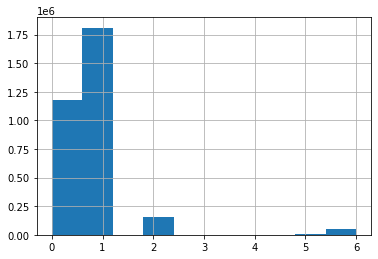

In [36]:
y_train.hist()

In [37]:
#median value of the number of samples in the classes.
#count = y_train.value_counts()
#n_samples = int(count.median())
#n_samples

In [38]:
"""
%%time
def sampling_strategy(X, y , n_samples, t='majority'):
    target_classes = ''
    
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
        
    tc = target_classes[target_classes == True].index
    #target_classes_all = y.value_counts().index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy
"""

"\n%%time\ndef sampling_strategy(X, y , n_samples, t='majority'):\n    target_classes = ''\n    \n    if t == 'majority':\n        target_classes = y.value_counts() > n_samples\n    elif t == 'minority':\n        target_classes = y.value_counts() < n_samples\n        \n    tc = target_classes[target_classes == True].index\n    #target_classes_all = y.value_counts().index\n    sampling_strategy = {}\n    for target in tc:\n        sampling_strategy[target] = n_samples\n    return sampling_strategy\n"

### Over sampling

In [39]:
"""
%%time
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# TMP
sampl_strategy = sampling_strategy(X_train,y_train,n_samples,t='minority')

print('Original dataset shape %s' % Counter(y_train))

rus = RandomOverSampler(sampling_strategy=sampl_strategy, random_state=SEED)
X_train, y_train = rus.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))
"""

"\n%%time\nfrom imblearn.over_sampling import RandomOverSampler\nfrom collections import Counter\n\n# TMP\nsampl_strategy = sampling_strategy(X_train,y_train,n_samples,t='minority')\n\nprint('Original dataset shape %s' % Counter(y_train))\n\nrus = RandomOverSampler(sampling_strategy=sampl_strategy, random_state=SEED)\nX_train, y_train = rus.fit_resample(X_train, y_train)\n\nprint('Resampled dataset shape %s' % Counter(y_train))\n"

### Under sampling

In [40]:
"""
%%time
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

sampl_strategy = sampling_strategy(X_train,y_train,n_samples,t='majority')

print('Original dataset shape %s' % Counter(y_train))

rus = RandomUnderSampler(sampling_strategy=sampl_strategy, random_state=SEED)
X_train, y_train = rus.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))
"""

"\n%%time\nfrom imblearn.under_sampling import RandomUnderSampler\nfrom collections import Counter\n\nsampl_strategy = sampling_strategy(X_train,y_train,n_samples,t='majority')\n\nprint('Original dataset shape %s' % Counter(y_train))\n\nrus = RandomUnderSampler(sampling_strategy=sampl_strategy, random_state=SEED)\nX_train, y_train = rus.fit_resample(X_train, y_train)\n\nprint('Resampled dataset shape %s' % Counter(y_train))\n"

In [41]:
#gc.collect()

# Deep Learning Model

In [42]:
model_tf = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(NFEATURES,)),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    
    #tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(rate=.2),
    
    tf.keras.layers.Dense(NCLASSES, activation = 'softmax')
])

model_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 9,287
Trainable params: 9,031
Non-trainable params: 256
_________________________________________________________________



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [43]:
model_tf.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

### Callbacks

In [44]:
DESIRED_ACCURACY = 0.98
  
class DesiredAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > DESIRED_ACCURACY):
            print("\nReached {}% accuracy so cancelling training!".format(DESIRED_ACCURACY))
            self.model.stop_training = True
        
desired_acc = DesiredAccuracy()

early_stop = tf.keras.callbacks.EarlyStopping(
    min_delta=0.00001, 
    patience=20, 
    restore_best_weights=True,
)

# Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 0.2 once learning stagnates. 
# This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, verbose=0,
    mode='min')

In [45]:
%%time

epochs=300

history = model_tf.fit(
      x=X_train, 
      y=y_train,
      batch_size=512,
      epochs=epochs,
      verbose=1,
      validation_data = (X_valid, y_valid),
      callbacks=[desired_acc, early_stop, plateau],
      #class_weight=weights
)

2022-01-01 08:52:42.400831: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
6250/6250 [==============================] - 32s 5ms/step - loss: 0.1439 - accuracy: 0.9433 - val_loss: 0.1047 - val_accuracy: 0.9543
Epoch 2/300
6250/6250 [==============================] - 31s 5ms/step - loss: 0.1017 - accuracy: 0.9557 - val_loss: 0.0952 - val_accuracy: 0.9579
Epoch 3/300
6250/6250 [==============================] - 32s 5ms/step - loss: 0.0963 - accuracy: 0.9574 - val_loss: 0.0911 - val_accuracy: 0.9590
Epoch 4/300
6250/6250 [==============================] - 31s 5ms/step - loss: 0.0937 - accuracy: 0.9581 - val_loss: 0.0903 - val_accuracy: 0.9593
Epoch 5/300
6250/6250 [==============================] - 32s 5ms/step - loss: 0.0921 - accuracy: 0.9587 - val_loss: 0.0881 - val_accuracy: 0.9598
Epoch 6/300
6250/6250 [==============================] - 33s 5ms/step - loss: 0.0909 - accuracy: 0.9590 - val_loss: 0.0875 - val_accuracy: 0.9600
Epoch 7/300
6250/6250 [==============================] - 40s 6ms/step - loss: 0.0901 - accuracy: 0.9592 - val_loss: 0.0874 -

In [46]:
%%time
preds_valid = np.argmax(model_tf.predict(X_valid), axis=1)
print('Valid accuracy:', accuracy_score(y_valid, preds_valid))

preds_train = np.argmax(model_tf.predict(X_train), axis=1)
print('Train accuracy:', accuracy_score(y_train, preds_train))

Valid accuracy: 0.96163625
Train accuracy: 0.9629765625
CPU times: user 3min 35s, sys: 1min 10s, total: 4min 46s
Wall time: 3min 17s


In [47]:
np.unique(preds_valid)

array([0, 1, 2, 3, 5, 6])

Max valid acc: 0.9616525173187256
Min valid loss: 0.08017408847808838


<Figure size 432x288 with 0 Axes>

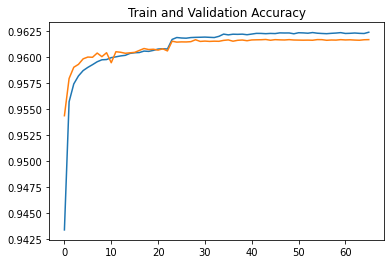

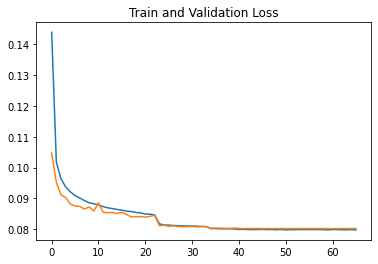

<Figure size 432x288 with 0 Axes>

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('Max valid acc:', max(val_acc))
print('Min valid loss:', min(val_loss))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(range(len(acc)), acc, label='Train Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Valid Accuracy')
plt.title ('Train and Validation Accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(range(len(loss)), loss, label='Train Loss')
plt.plot(range(len(val_loss)), val_loss, label='Valid Loss')
plt.title ('Train and Validation Loss'   )
plt.figure()

**Confusion matrix**

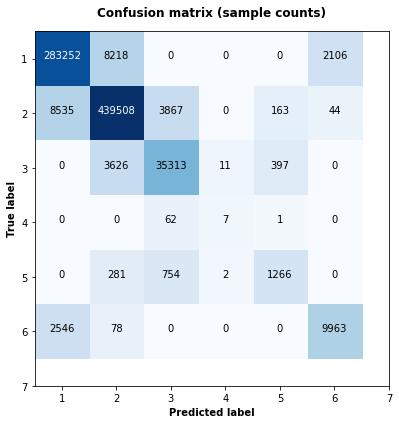

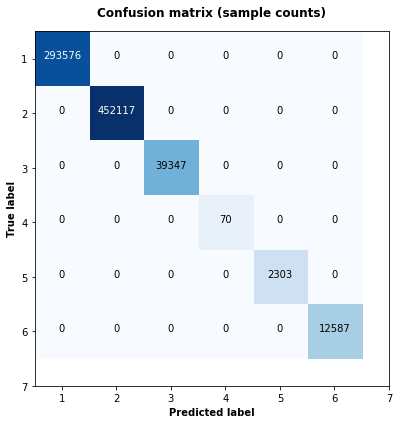

In [49]:
    from sklearn.metrics import confusion_matrix
    from sklearn.preprocessing import minmax_scale
    import itertools
    
    def plot_confusion_matrix(cm, classes, cm_type='recall'):
        if cm_type == 'recall':
            cm = cm / cm.sum(axis=1).reshape(-1, 1)
            colors = cm
            cell_format = '.0%'
            plt.title('Confusion matrix (sum of every row is 100 %, diagonal shows recall)', fontweight='bold', pad=15)
        elif cm_type == 'precision':
            cm = cm / cm.sum(axis=0).reshape(1, -1)
            colors = cm
            cell_format = '.0%'
            plt.title('Confusion matrix (sum of every column is 100 %, diagonal shows precision)', fontweight='bold', pad=15)
        elif cm_type == 'accuracy':
            cm = cm / cm.sum()
            colors = minmax_scale(cm.reshape(-1, 1)).reshape(cm.shape[0], cm.shape[1]) ** 0.3 # make the low-to-medium cells darker
            cell_format = '.2%'
            plt.title('Confusion matrix (sum of matrix is 100 %, sum of diagonal shows accuracy)', fontweight='bold', pad=15)
        elif cm_type == 'count':
            colors = minmax_scale(cm.reshape(-1, 1)).reshape(cm.shape[0], cm.shape[1]) ** 0.3 # make the low-to-medium cells darker
            cell_format = 'd'
            plt.title('Confusion matrix (sample counts)', fontweight='bold', pad=15)
        else: raise ValueError(f'Illegal value for parameter cm_type: {cm_type}')
        plt.imshow(colors, interpolation='nearest', cmap=plt.cm.Blues) # or cmap='hot'
        #plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)

        thresh = colors.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            value = cm[i, j]
            plt.text(j, i, format(value, cell_format),
                     horizontalalignment="center",
                     color="white" if colors[i, j] > thresh else "black")

        plt.ylabel('True label', fontweight='bold')
        plt.xlabel('Predicted label', fontweight='bold')
        plt.tight_layout()

    
    cm = confusion_matrix(y_valid, preds_valid)
    #plt.figure(figsize=(11, 9))
    #plot_confusion_matrix(cm, le.inverse_transform(np.arange(len(le.classes_))), cm_type='accuracy')
    #plt.show()

    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cm, le.inverse_transform(np.arange(len(le.classes_))), cm_type='count')
    plt.show()
    
    cm = confusion_matrix(y_valid, y_valid)
    #plt.figure(figsize=(8,6))
    #plot_confusion_matrix(cm, le.inverse_transform(np.arange(len(le.classes_))), cm_type='accuracy')
    #plt.show()

    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cm, le.inverse_transform(np.arange(len(le.classes_))), cm_type='count')
    plt.show()

# Submit

In [50]:
%%time
samp_sub = dt.fread('../input/tabular-playground-series-dec-2021/sample_submission.csv').to_pandas()
preds_test = np.argmax(model_tf.predict(test), axis=1)
preds_test_sub = le.inverse_transform(preds_test)

output = pd.DataFrame({'Id': samp_sub['Id'],
                       'Cover_Type': preds_test_sub.flatten()})

output.to_csv('submission_dec_12_21.csv', index=False)

CPU times: user 1min 4s, sys: 16.2 s, total: 1min 20s
Wall time: 59.6 s


In [51]:
output.Cover_Type.value_counts()

2    513464
1    386773
3     78206
7     15613
6      5817
4       127
Name: Cover_Type, dtype: int64

In [52]:
print('The end.')

The end.
